# Investigating Fisheries Collapse of the North-Atlantic Cod 🐟


![](https://espm-157.github.io/website-r/img/cod.jpg)

_Figure from the Millennium Ecosystem Assessment Project using the RAM data._





## Introduction
This notebook will focus on examining the fisheries collapse from 1850 to 2020 across different regions, namely Canada East Coast, European Union, US East Coast, and Europe non-European Union (Europe non-EU). The data we will be using will be from the RAM Legacy Stock Assessment Database, which will be accessed and streamed from HuggingFace. As human-induced activities seize to rapidly dominate marine ecosystems at an accelerating rate, analyzing long-term regional time series and evaluating total fisheries catch at a temporal and spatial scale are crucial to improving current marine conservation efforts.

**Data Source:** <https://huggingface.co/datasets/cboettig/ram_fisheries/tree/main/v4.65>



Below, we import the necessary libraries for this notebook and load in our 5 datasets.

In [227]:
import ibis
from ibis import _
import ibis.selectors as s
from plotnine import *
con = ibis.duckdb.connect()
con.con.execute("INSTALL httpfs")
con.con.execute("LOAD httpfs")

In [228]:
area = con.read_csv('https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/area.csv');
assessment = con.read_csv('https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/assessment.csv');
stock = con.read_csv('https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/stock.csv');
timeseries = con.read_csv('https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/timeseries.csv');
tsmetrics = con.read_csv('https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/tsmetrics.csv');

In [229]:
fish = (timeseries
        .join(stock, "stockid")
        .join(area, "areaid")
        .join(assessment, "assessid")
        .join(tsmetrics.rename(tsid = "tsunique"), "tsid")
)
fish.execute().head()

,assessid,stockid,stocklong,tsid,tsyear,tsvalue,tsn,scientificname,commonname,areaid,...,refpoints,assessmethod,assesscomments,xlsfilename,mostrecent,tscategory,tsshort,tslong,tsunitsshort,tsunitslong
0,DFO-HERRPRD-1951-2015-WATSON,HERRPRD,Pacific herring Prince Rupert District,TBbest-MT,2007,33200,551209,Clupea pallasii,Pacific herring,Canada-DFO-PRD,...,1,SCA,NULL,WATSON_HERRPRD_2015-DH-edited.xlsx,0,TOTAL BIOMASS,TBbest,General total biomass time series (TB then con...,MT,Metric tons
1,DFO-HERRPRD-1951-2015-WATSON,HERRPRD,Pacific herring Prince Rupert District,TBbest-MT,2008,33900,551209,Clupea pallasii,Pacific herring,Canada-DFO-PRD,...,1,SCA,NULL,WATSON_HERRPRD_2015-DH-edited.xlsx,0,TOTAL BIOMASS,TBbest,General total biomass time series (TB then con...,MT,Metric tons
2,DFO-HERRPRD-1951-2015-WATSON,HERRPRD,Pacific herring Prince Rupert District,TBbest-MT,2009,34700,551209,Clupea pallasii,Pacific herring,Canada-DFO-PRD,...,1,SCA,NULL,WATSON_HERRPRD_2015-DH-edited.xlsx,0,TOTAL BIOMASS,TBbest,General total biomass time series (TB then con...,MT,Metric tons
3,DFO-HERRPRD-1951-2015-WATSON,HERRPRD,Pacific herring Prince Rupert District,TBbest-MT,2010,41200,551209,Clupea pallasii,Pacific herring,Canada-DFO-PRD,...,1,SCA,NULL,WATSON_HERRPRD_2015-DH-edited.xlsx,0,TOTAL BIOMASS,TBbest,General total biomass time series (TB then con...,MT,Metric tons
4,DFO-HERRPRD-1951-2015-WATSON,HERRPRD,Pacific herring Prince Rupert District,TBbest-MT,2011,38400,551209,Clupea pallasii,Pacific herring,Canada-DFO-PRD,...,1,SCA,NULL,WATSON_HERRPRD_2015-DH-edited.xlsx,0,TOTAL BIOMASS,TBbest,General total biomass time series (TB then con...,MT,Metric tons


In [230]:
cod_catch_region = (fish
       .filter(_.tsid == "TCbest-MT")
       .filter(_.commonname == "Atlantic cod")
       .filter(_.tsvalue != "NA")
       .group_by(_.tsyear, _.stocklong, _.region, _.primary_FAOarea)
       .agg(mean_catch = _.tsvalue.cast("float64").mean())
       .group_by(_.tsyear, _.region, _.primary_FAOarea)
       .agg(total_catch = _.mean_catch.sum())
       )

cod_catch_region_df = cod_catch_region.execute()

fao_mapping = {
    21 : "Northwest Atlantic",
    27 : "Northeast Atlantic"
}

cod_catch_region_df['FAO_Area_Name'] = cod_catch_region_df['primary_FAOarea'].map(fao_mapping)
cod_catch_region_df

,tsyear,region,primary_FAOarea,total_catch,FAO_Area_Name
0,1964,Canada East Coast,21,1.363387e+06,Northwest Atlantic
1,1995,Canada East Coast,21,3.300059e+04,Northwest Atlantic
2,1991,Canada East Coast,21,4.664398e+05,Northwest Atlantic
3,1875,Canada East Coast,21,1.700000e+05,Northwest Atlantic
4,1933,Canada East Coast,21,2.811060e+05,Northwest Atlantic
...,...,...,...,...,...
362,1963,European Union,27,2.435623e+05,Northeast Atlantic
363,1859,Canada East Coast,21,1.540000e+05,Northwest Atlantic
364,1877,Canada East Coast,21,1.580000e+05,Northwest Atlantic
365,1981,US East Coast,21,4.660000e+04,Northwest Atlantic


This dataframe is intended to closely evaluate the temporal and spatial changes of total fisheries catch over the years and differences between regions and the Food and Agriculture Organization of the United Nations (FAO) Areas. The column "tsyear" contains years spanning from 1850 to 2022; "region" contains four regions such as Europe non-European Union, US East Coast, European Union, and the Canada East Coast; "primary_FAOarea" contains two numbered regions, 21 and 27, which are specified in column "FAO_Area_Name" as Northwest Atlantic and Northeast Atlantic, respectively; and "total_catch" contain the total number of fishery catches in the unit of metric tons.

In order to understand the trends of total catch over the years, "TCBest-MT" was selected from the "tsid" column, which represents the total quanity of fish removed from the water with the best estimate in metric tons. Afterwards, the function group_by() and agg() is applied to compute the mean catch per stock year because some stocks may contain multiple observations or subrecords. The second group_by() and agg() functions are intended to take those stock-level averages and sum them to get the total catch per region per year.

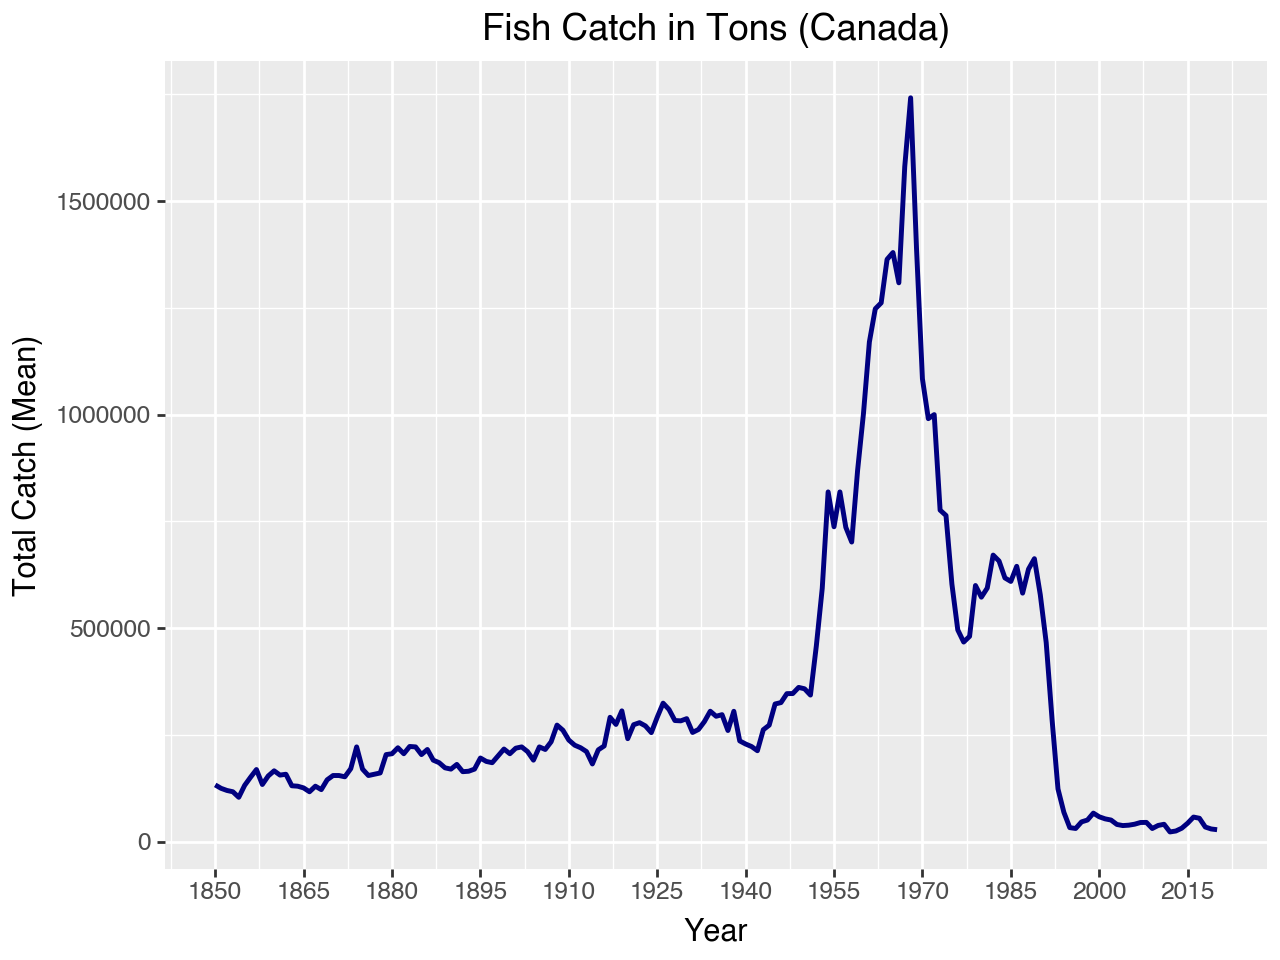

In [231]:
cod_canada_ = cod_catch_region_df[cod_catch_region_df['region'].isin(['Canada East Coast'])]

(
    ggplot(cod_canada_, aes(x='tsyear', y='total_catch'))
    + geom_line(size = 1, color='navy')
    + labs(
        title="Fish Catch in Tons (Canada)",
        x="Year",
        y="Total Catch (Mean)"
    )
    + scale_x_continuous(limits=(1850, 2020), breaks=range(1850, 2025, 15))
)

_**Figure 1:** This plot closely looks at the temporal trends of the North Atlantic Cod species from the Canada East Coast region over the years of 1850 to 2022. At first glace, we see a stagnant upward trend in total fish catchings from 1850 to 1940, and eventually a dramatic spike between the years of 1950 to 1970 with over 15,000,000 metric tons. The subsequent years after 1970 display a second spike in 1985 and a rapid decline in total catchings in the early 2000s. These trends suggest that the Atlantic fishery abruptly collpased in 1993 after extreme overfishing activities in the late 1950s. Introduction of industrial-scale fishing technologies such as trawlers, sonar, and radar alluded global countries to travel to the Canada East Coast for fishery exploitation. The dramatic reduction in fishing since 1993 has enabled the North Atlantic Cod to recover a bit, however they still remain scarce compared to earlier years._

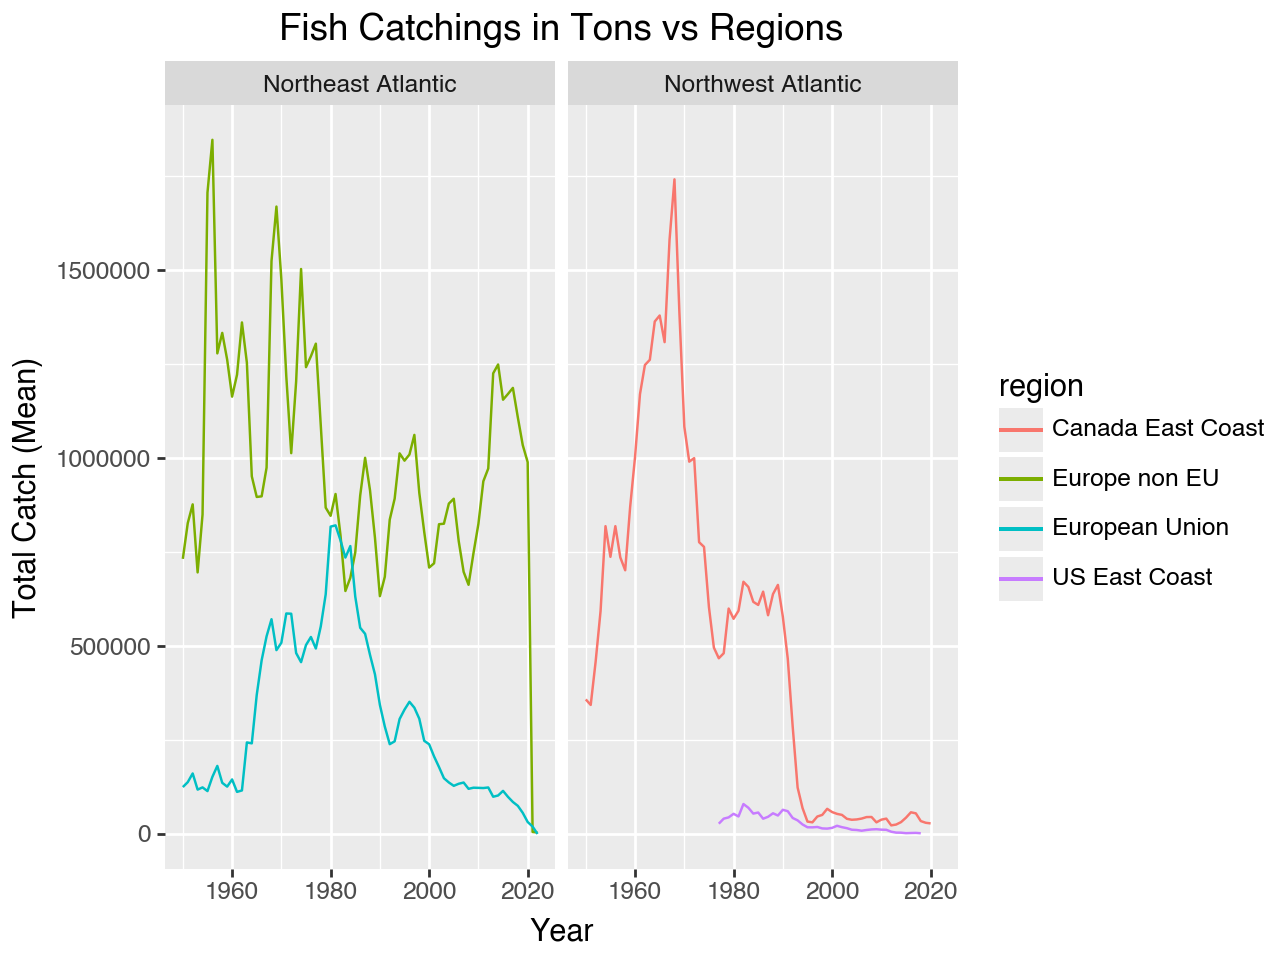

In [232]:
cod_catch = cod_catch_region_df[cod_catch_region_df['tsyear'] >= 1950]
(
    ggplot(cod_catch, aes(x='tsyear', y='total_catch', group='region', color='region'))
    + geom_line()
    + facet_wrap('~FAO_Area_Name', ncol=2)
    + labs(title="Fish Catchings in Tons vs Regions", x="Year", y="Total Catch (Mean)")
)

_**Figure 2:** This plot compares the total catchings of the North Atlantic Cod between two FAO Areas, the Northeast Atlantic and Northwest Atlantic within the years 1950 - 2022. By looking at the regional differences between Canada East Coast, Europe non-European Union, European Union, and the US East Coast as well as post-1950s, we can better understand the temporal and spatial trends of each region and the progressive fishery conservation efforts post-World War II when industrial tools were introduced. The Northeast Atlantic plot, containing regions European non-European Union and the European Union, displays varying trends. Europe non-EU had a spike in total catchings of over 1000000 metric tons between 1960 - 1970 and slowly made progressive efforts in decreasing fishing activities between 1980 - 2010. The European Union, on the other hand, had a similar spike in fishing catchings with the Canada East Coast between 1960 - 1980, and eventually had a decline in fishery activities leading up to 2020. Lastly, the US East Coast display minimal total catchings fishery activities from 1980 to 2020 possibly due to stricter federal regulations such as the Magnuson-Stevens Act (MSA) of 1976 or limited recovery of the Atlantic Cod that prevented extensive overfishing activities from occurring._

**Top 5 Stocks Per FAO Area**

In [233]:
cod_stocks_fao = (
    fish
    .filter(_.tsid == "TCbest-MT")
    .filter(_.commonname == "Atlantic cod")
    .filter(_.tsvalue != "NA")
    .group_by(_.tsyear, _.region, _.stocklong, _.primary_FAOarea)
    .agg(mean_catch = _.tsvalue.cast("float64").mean())
    .group_by(_.tsyear, _.region,_.stocklong, _.primary_FAOarea)
    .agg(total_catch = _.mean_catch.sum())
)
cod_stocks_fao_df = cod_stocks_fao.execute()
cod_stocks_fao_df['FAO_Area_Name'] = cod_stocks_fao_df['primary_FAOarea'].map(fao_mapping)
cod_stocks_fao_df['stocklong'] = cod_stocks_fao_df['stocklong'].str.replace('^Atlantic cod ', '', regex = True)

**Calculating Top 5 Stocks**

In [234]:
mean_catch_per_stock = (
    cod_stocks_fao_df
    .groupby(['FAO_Area_Name', 'stocklong'], as_index=False)['total_catch']
    .mean()
    .rename(columns={'total_catch': 'avg_catch'})
)

top5_per_fao = (
    mean_catch_per_stock
    .sort_values(['FAO_Area_Name', 'avg_catch'], ascending=[True, False])
    .groupby('FAO_Area_Name')
    .head(5)
)

top_stocks = top5_per_fao['stocklong'].unique()
cod_top_df = cod_stocks_fao_df[cod_stocks_fao_df['stocklong'].isin(top_stocks)]
cod_top_df.head()

,tsyear,region,stocklong,primary_FAOarea,total_catch,FAO_Area_Name
0,1963,Canada East Coast,Eastern Scotian Shelf,21,68200.0,Northwest Atlantic
21,1850,Canada East Coast,Southern Labrador-Eastern Newfoundland,21,133000.0,Northwest Atlantic
22,1853,Canada East Coast,Southern Labrador-Eastern Newfoundland,21,117000.0,Northwest Atlantic
23,1855,Canada East Coast,Southern Labrador-Eastern Newfoundland,21,132000.0,Northwest Atlantic
24,1863,Canada East Coast,Southern Labrador-Eastern Newfoundland,21,131000.0,Northwest Atlantic


_This dataframe contains the same columns as the previous dataframe, namely the year, region, primary FAO Area number, total catch, and FAO Area Name, but this time introduces the "stocklong" column, which is the specific type of North Atlantic Cod species. By exploring and identifying specific species pertaining to specific regions, we can scrutinize on why certain species are exploited over the others. Additionally, by selecting just the top five stocks from each of the two FAO areas, we focus on relevant species that are exploited the most within the respective regions. We group the "FAO_Area_Name" and "stocklong" columns and find the average catch to summarize the dataset so that each stock has a single representative value within each FAO region. Subsequently, we sort the values of those two columns and group by the "FAO_Area_Name" in order to find the top five cod stocks in each FAO area, ranked by the average catch._

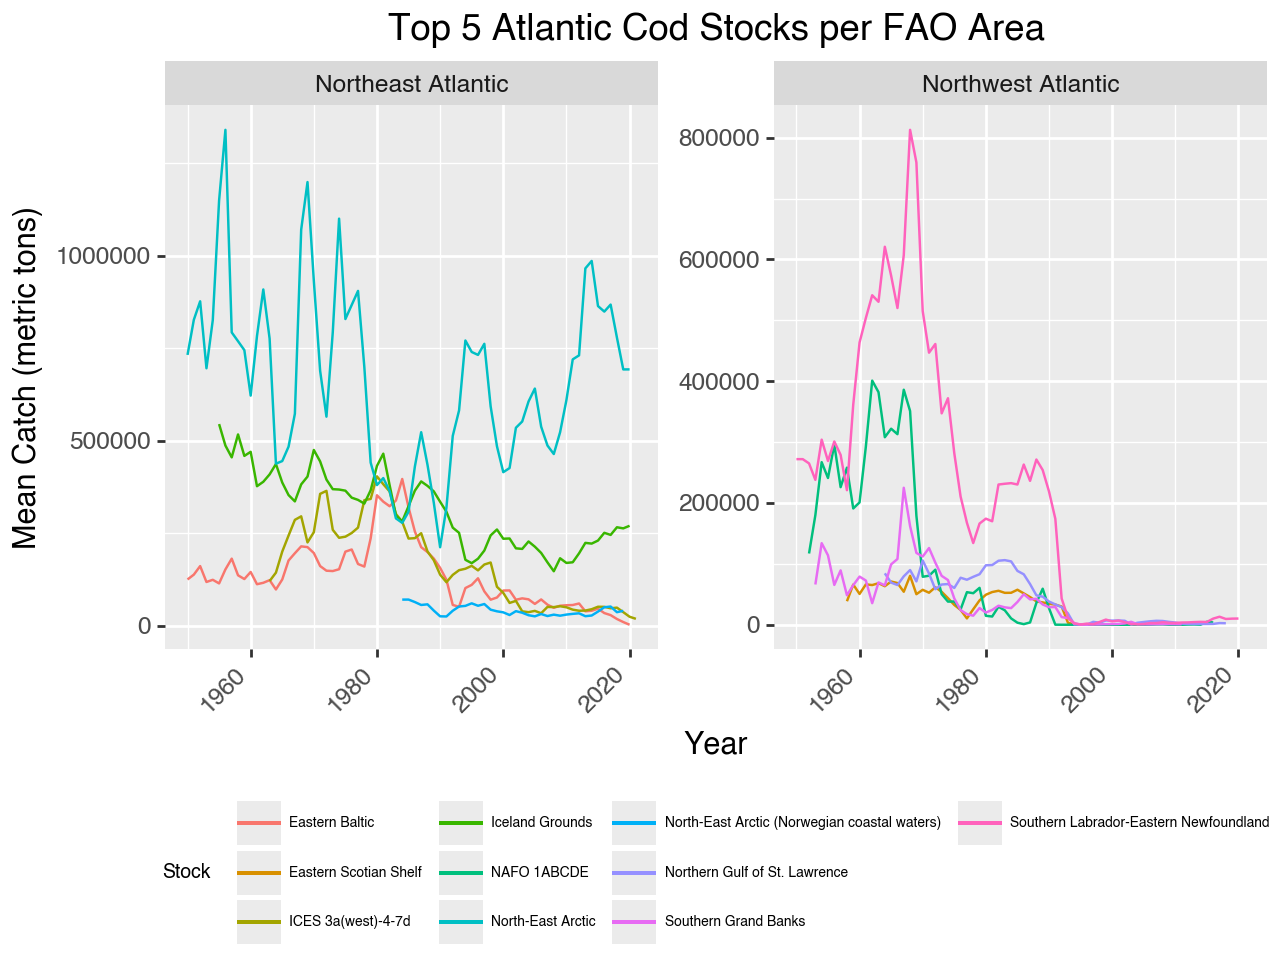

In [235]:
cod_catch = cod_top_df[cod_top_df['tsyear'] >= 1950]
(
    ggplot(cod_catch, aes(x='tsyear', y='total_catch', color='stocklong'))
    + geom_line()
    + facet_wrap('~FAO_Area_Name', ncol=2, scales='free_y')
    + labs(title='Top 5 Atlantic Cod Stocks per FAO Area',
           x='Year', y='Mean Catch (metric tons)', color='Stock')
    + theme(legend_position='bottom',
            legend_box='vertical',
            legend_text=element_text(size=5),
            legend_title=element_text(size=7),
            axis_text_x=element_text(rotation=45, hjust=1))
    + guides(color=guide_legend(nrow=3))
)

_**Figure 3:** This plot displays the top five North Atlantic Cod Stocks per FAO Area, the Northeast Atlantic and Northwest Atlantic, over the years spannng from 1960 - 2020. Looking closely in the Northeast Atlantic region, the North-East Arctic species following the Iceland Grounds and the Eastern Baltic species show evident changes in fishing catchings over the years. The North-East Arctic is the most common species harvested, reaching over 1,000,000 tons in catches in 1960, and continue to be exploited until 1993. On the other hand with the Northwest Atlantic region, the Southern Labrador-Eastern Newfoundland species and the NAFO 1ABCDE species, which represents species off West Greenland, demonstrate a significant spike in total catchings between 1960-1970._

# Investigating Global Stock Collapses 📉

We'll now explore the total global stock collapses between 1950 and 2020. A stock is considered collapsed if the total catch in any given year is less than 10% of its historic maximum. In particular, we seek to use updated data to replicate the temporal trend in stock declines shown in [Worm et al 2006](http://doi.org/10.1126/science.1132294):

![](https://espm-157.github.io/website-r/img/worm2006.jpg)

The data plotted above have been aggregated by regions of low (<500) and high (>500) species diversity, represented in blue and red respectively. It has also been analyzed in terms of both cumulative collapses (triangles) and annual collapses (diamonds); cumulative collapses consider a species collapsed if at any point the total catch metric dips below 10 percent of its historic maximum (even if the species recovers), while annual collapses only counts the proprotion of species that are considered collapsed in each individual year for which data is available. 

For simplicity, we will only attempt to replicate the overall collapses by year, represented with the black diamonds in the above graph. We will also consider taxa that are the same species appearing in different regions to be different stocks, so that we can analyze stock collapses by region to compare with our earlier analysis of the Atlantic Cod. 

In the cell below, we select the TCbest-MT metric: this describes the total catch in metric tons as reported by fisheries; when total catch is unavailable, the TCbest-MT metric may subsitute the total landings. We remove rows for which no data is vailable, and aggregate over year, region, and commonname, giving us an individual row in the table for every species that appears in each region annually (for example, Atlantic cod on the Canada East Coast in 1957 and Atlantic cod on the US East Coast in 1957 will be two separate rows.)

In [236]:
catch=(fish
       .filter(_.tsid == "TCbest-MT")
       .filter(_.tsvalue != "NA")
       .group_by(_.tsyear, _.region, _.commonname)
       .agg(total_catch = _.tsvalue.cast("float64").sum())
       )

catch.head().execute()

,tsyear,region,commonname,total_catch
0,1964,Canada West Coast,Pacific herring,565554.4230
1,1968,Canada West Coast,Pacific herring,17157.0668
2,1975,Canada West Coast,Pacific herring,156375.1028
3,1985,Canada West Coast,Pacific herring,75983.5341
4,1990,Canada West Coast,Pacific herring,114816.0463


In the cell below, we add a few extra columns to the dataframe that will help us with our analysis of collapsed fisheries. We order by year and use the cummmax() function to create a new column that has the maximum catch for that fish in that region up to and including that row. We can then use the relationship between historic max and the catch for that year to determine whether or not that stock has collapsed; as we described earlier, the percent collapse is the difference between the historic max and the total catch in any given year divided by the historic maximum catch. Finally, if the percent collapse is greater than 90%, we mark the stock as collapsed for that year in the 'collapsed' column with a 1 (the default value is 0, indicating that that stock is not collapsed). 

*Note: While the original study counted the collapses cumulatively (if the stock had collapsed at any point it would be considered collapsed, even if it recovered later), we will only be looking at annual collapses for simplicity.*

In [237]:
collapsed = (
    catch
    .filter(_.tsyear >= 1950)
    .group_by(_.region, _.commonname)
    .order_by(_.tsyear)
    .mutate(historic_max = _.total_catch.cummax())
    .mutate(
        percent_collapse = ibis.cases(
            (_.historic_max == 0, 0),
            else_ = (_.historic_max - _.total_catch) / _.historic_max * 100
        )
    )
    .mutate(
        collapsed = ibis.cases(
            (_.historic_max == 0, 0),
            (_.percent_collapse >= 90, 1),
            else_ = 0
        )
    )
)

collapsed.head(5).execute()

,tsyear,region,commonname,total_catch,historic_max,percent_collapse,collapsed
0,1950,Atlantic Ocean,Skipjack tuna,1408.0,1408.0,0.000000,0
1,1951,Atlantic Ocean,Skipjack tuna,1377.0,1408.0,2.201705,0
2,1952,Atlantic Ocean,Skipjack tuna,5431.0,5431.0,0.000000,0
3,1953,Atlantic Ocean,Skipjack tuna,6200.0,6200.0,0.000000,0
4,1954,Atlantic Ocean,Skipjack tuna,6270.0,6270.0,0.000000,0


Now we'll group this by year to determine the total fraction of fish stocks (for which data are available in that year) are collapsed in every year since 1950. We also add the number of taxa for which data is available in each year, and the number collapsed. Some of the more recent years have data for less taxa than earlier years, as we can see in the table below.

In [238]:
collapsed_stocks = (collapsed
                  .group_by(_.tsyear)
                  .agg(_.commonname.count().name('num_stocks'), 
                       _.collapsed.sum().name('num_collapsed'))
                  .mutate(percent_collapsed = (_.num_collapsed / _.num_stocks) * 100)
                  .order_by(_.tsyear.desc())
)

collapsed_stocks.head(20).execute()

,tsyear,num_stocks,num_collapsed,percent_collapsed
0,2023,3,3,100.000000
1,2022,38,33,86.842105
2,2021,68,54,79.411765
3,2020,154,98,63.636364
4,2019,213,106,49.765258
5,2018,297,118,39.730640
6,2017,322,114,35.403727
7,2016,368,121,32.880435
8,2015,394,103,26.142132
9,2014,403,94,23.325062


From 2018 onward, there are data for fewer than 300 stocks in the table above, while the earlier years consistently have around 500. Starting in 2019, the total number of stocks collapsed also begins decreasing consistently, which indicates that our dataset is not complete enough to be useful for our analysis. We also see a sharp upward trend in the percent collapsed metric as the number of stocks declines. For these reasons, we will only be considering years before 2018 in the rest of our analysis (years with greater than 300 stocks). We modify the collapsed stocks table and plot it below.

In [239]:
collapsed_stocks = (collapsed_stocks
                  .filter(_.tsyear < 2018)
).execute()

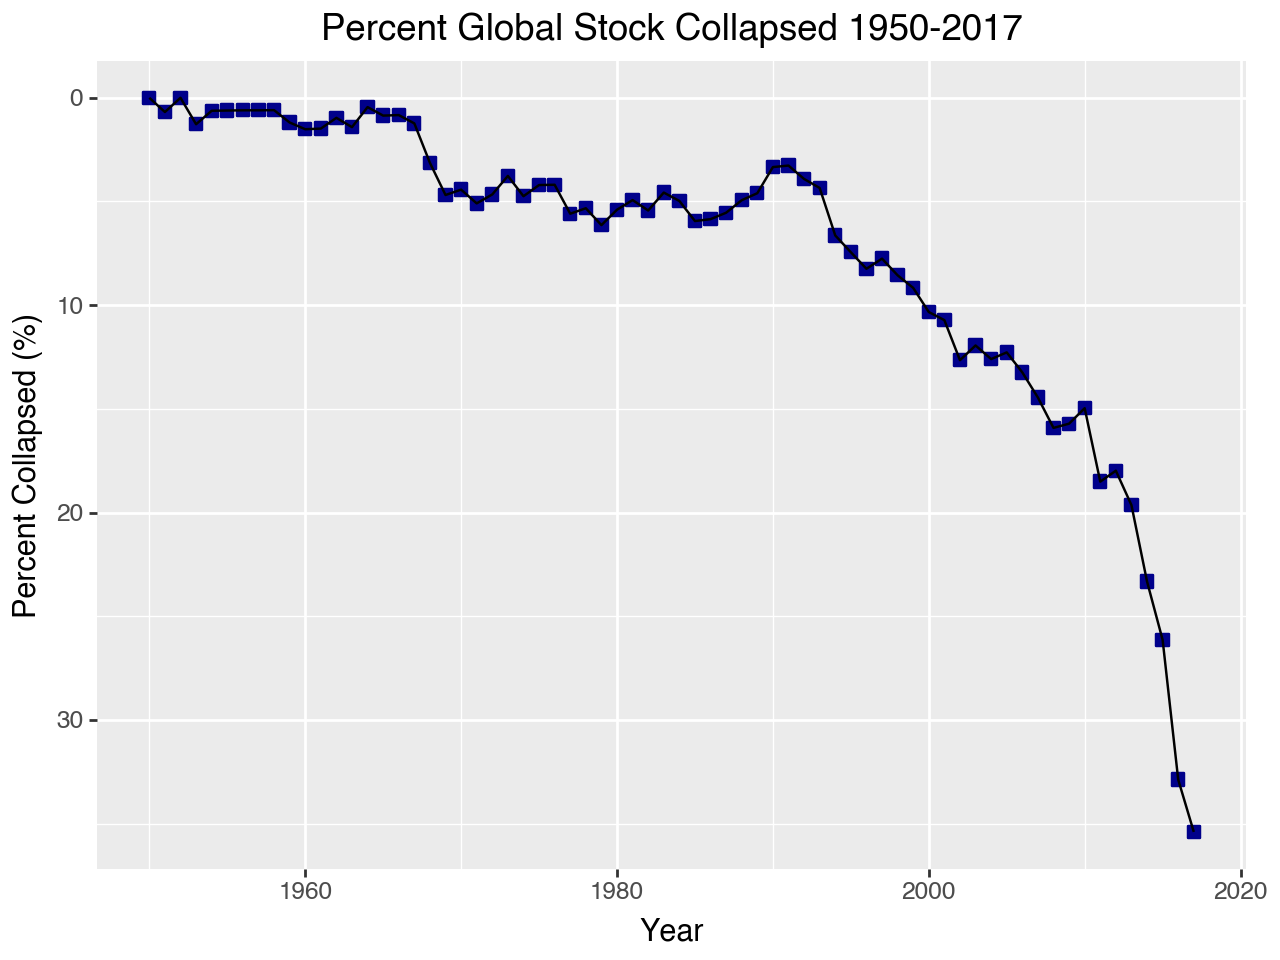

In [240]:
(
    ggplot(collapsed_stocks, aes(x='tsyear', y='percent_collapsed')) 
    + geom_point(size = 2, color='darkblue', shape='s') 
    + scale_y_reverse()
    + labs(title='Percent Global Stock Collapsed 1950-2017',
           x='Year', y='Percent Collapsed (%)')
    + geom_line()
)

_**Figure 4:** The plot above shows the percent of the global stocks that are considered collapsed in each year between 1950 and 2017. The overall trend appears to show that the percent of collapsed stocks appear to be exponentially increasing (higher values appear towards the bottom of the graph for visual consistency with Worm et al), which is consistent with the trends found in Worm et al 2006. Additionally, the 10 additional years of data we have included in our figure shows that the downward trend has continued or worsened in the last decade. This highlights the challenges – overfishing, pollution, climate change – that fish stocks around the globe are facing, and emphasizes the conclusion that the problem is an alarming trend, not an anomaly or a handful of bad years._

### **Regional breakdown**

Next, we'll look a little closer and figure out which regions have the sharpest increases in collapsed fish stocks. Are all regions struggling, or are some regions facing severe collapses while others appear to be normal? 

To pick our regions to focus on, we've created a small table with the regions with the highest number of stocks for any given year. Choosing regions with many stocks allows us to see trends that might be obscured by randomness that comes with smaller datasets.  

In [241]:
regions = (collapsed
           .group_by(_.tsyear, _.region)
           .agg(_.commonname.count().name('num_stocks'))
                .group_by(_.region)
                .agg(_.num_stocks.max().name('max_stocks'))
                .order_by(_.max_stocks.desc())
                ).head(20).execute()

regions.head(6)

,region,max_stocks
0,European Union,72
1,Japan,46
2,US East Coast,46
3,US West Coast,42
4,West Africa,36
5,Canada East Coast,36


To investigate the trend for each region, we'll follow the same procedure as for global stock collapses but we'll group our stocks by region and plot them separately.

*Note: West Africa has no data prior to 1980, which makes it more difficult to compare to the others. Instead we will subsitute European non EU, which is one of the regions chosen in our analysis of the Atlantic cod in section 1 of the notebook.*

In [242]:
collapsed_taxa_regional = (collapsed
                           .filter(_.tsyear < 2018)
                           .filter(_.region.isin(['US East Coast', 'Canada East Coast', 
                                                  'Europe non EU', 'European Union', 
                                                  'Japan', 'US West Coast']))
                         .group_by(_.tsyear, _.region)
                         .agg(_.commonname.count().name('num_taxa'), 
                              _.collapsed.sum().name('num_collapsed'))
                         .mutate(percent_collapsed = (_.num_collapsed / _.num_taxa) * 100)
).execute()

collapsed_taxa_regional.head()

,tsyear,region,num_taxa,num_collapsed,percent_collapsed
0,2007,European Union,67,9,13.432836
1,1969,European Union,21,0,0.000000
2,1972,European Union,28,1,3.571429
3,2001,Japan,46,4,8.695652
4,1962,US East Coast,18,0,0.000000


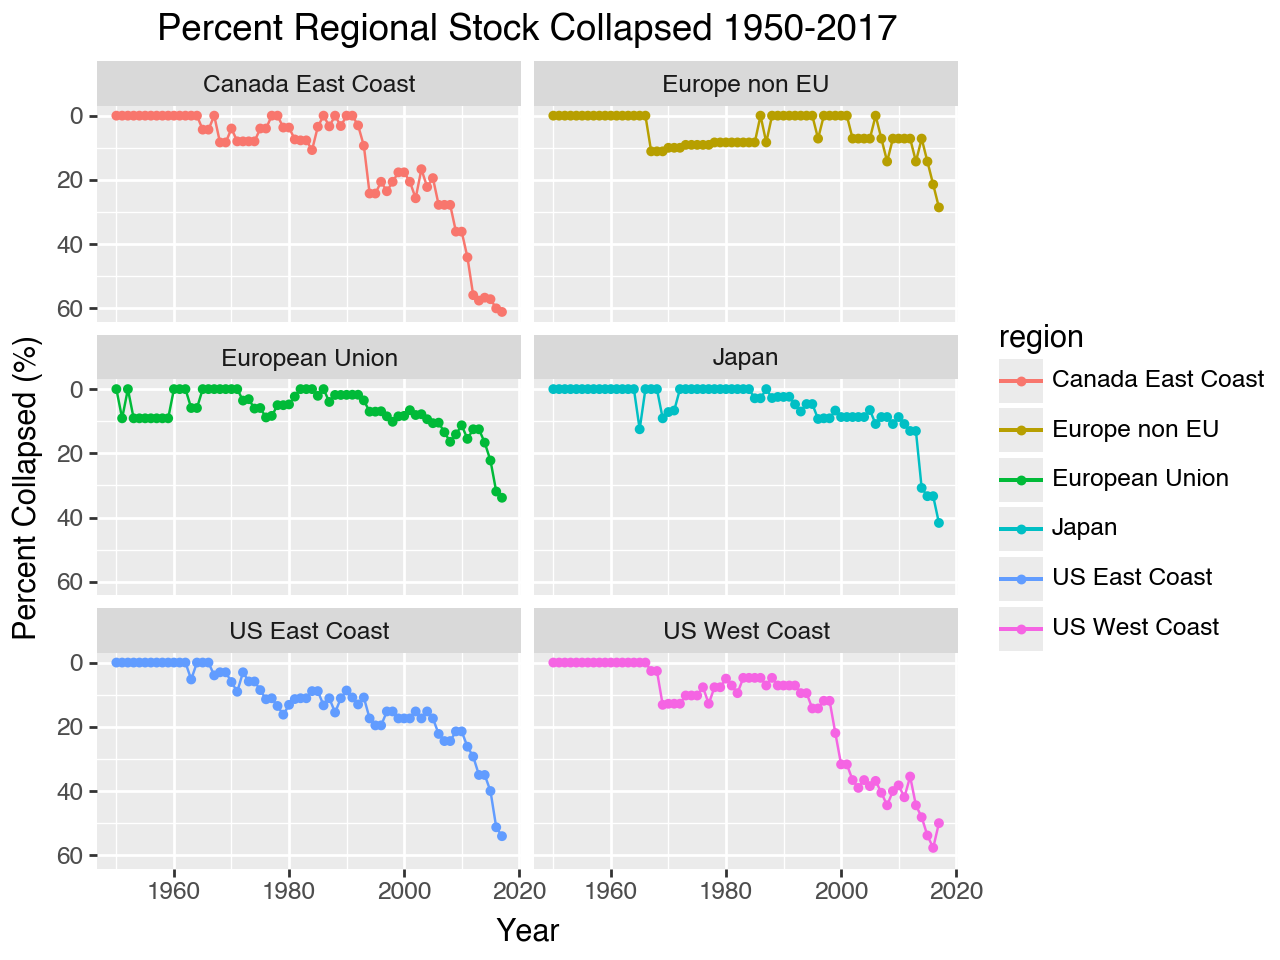

In [243]:
(
    ggplot(collapsed_taxa_regional, aes(x='tsyear', y='percent_collapsed', color='region')) 
    + geom_point(size = 1) 
    + scale_y_reverse()
    + facet_wrap('~region', ncol = 2, scales = "fixed")
    + labs(title='Percent Regional Stock Collapsed 1950-2017',
           x='Year', y='Percent Collapsed (%)')
    + geom_line()
    
)

_**Figure 5:** The plot above shows the percent of the stocks in each region that are considered collapsed in each year between 1950 and 2017. The stocks in Europe (both the European Union and Europe non EU) and Japan appear to be doing similarly to global average stocks, each exhibiting moderate declines. The Canada and US East and West Coasts, however, appear to be doing particularly poorly. The percent collapse in the most recent years of data are between 50 and 60% - more than half._

***

## Conclusion:

In this notebook, we have investigated the collapse of global fish stock over the last 70 years. We started by visualizing the rise and fall of the Atlantic Cod in the Canada East Coast region (Figure 1), similarly to the visuals in the paper published by Worm et al in 2006. We then explored the collapse of fish stocks around the world, showing that the trend of increasing collapses observed in Worm's paper has continued, considering over a decade of new data. By breaking the collapse up by region, we observed that, while all the regions we focused on are experiencing increasing stock collapses, some regions are affected far more severely than others. It is crucial that we continue to monitor the state of these important species to guide conservation efforts and to better understand how overfishing, pollution, climate change, and other human activity are affecting marine ecosystems.